# CNN Model for Predicting Age from 12-lead ECG signals

In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


### Loading raw Data into Mutable Dataframes

In [2]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    sampling_rate=100
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, 100, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)



## Data Augmentation
* Pulled a few DA augmentation methods from the Sensors paper.
* Source: https://pubmed.ncbi.nlm.nih.gov/37299964/

### Quality Filter

In [3]:
# X = X[(Y.validated_by_human == True)]
# Y = Y[(Y.validated_by_human == True)]

### Band Pass Filter
* fs (Sampling frequency): It represents the rate at which the input signal is sampled. Our data is 100hz.

* lowcut (Lower cutoff frequency): Determines the lower boundary of the frequency range that is allowed to pass through the filter. Frequencies outside this cutoff are reduced in strength instead of cut off.

* highcut (Higher cutoff frequency): Determines the upper boundary of the frequency range that is allowed to pass through the filter. 

* filter_order (Filter order): The filter order determines the sharpness of the frequency curve. The frequencies that fall out of the lowcut - highcut boundary are attentuated in strength according to the filter order. A higher filter order generally results in a steeper frequency outside the passband. 

Resource: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [4]:
import numpy as np
from scipy import signal
with tf.device('/CPU:0'):
    # Define the filter parameters
    fs = 100  # Sampling frequency (Hz)
    lowcut = 0.5  # Lower cutoff frequency (Hz)
    highcut = 40.0  # Higher cutoff frequency (Hz)
    filter_order = 4  # Filter order

    def bandpass(X, fs, lowcut, highcut, filter_order):
        # Apply bandpass filter to each channel
        filtered_data = np.zeros_like(X)
        for i in range(X.shape[2]):
            for j in range(X.shape[0]):
                b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
                filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

        # Print the shape of the filtered data
        return filtered_data

### Baseline Drift and Normalization
* Normalizing the Data
    * Normalized by the mean of the entire data set
    * Changed from normalizing according to individual leads.
* Simulating baseline drift in the training data.
    * Improves data variety
    * Prepares the model for unexpectedly different test data

In [5]:
with tf.device('/CPU:0'):
    def normalize(X, shape = False):
        # Compute mean and standard deviation along axis 1 and 2
        X_mean = np.mean(X)
        X_std = np.std(X)

        if(shape):
            print(X.shape)
        # Normalize data by subtracting mean and dividing by standard deviation
        return ((X - X_mean) / X_std)


    bld = 0.5
    def baseline_drift(X, baseline, range = 0):
        bld_range = (baseline-range, baseline+range)
        random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
        return X + random_shifts

### DA Applyer

In [6]:
with tf.device('/CPU:0'):
    def da_apply(X, functions, shape = False):
        X_final = X.copy()

        # Applys DA Augments in specified order
        for func_dict in functions:
            func = func_dict['func']
            if(func_dict['params'] == None):
                X_final = func(X_final)     
            else:
                params = func_dict['params']
                X_final = func(X_final, *params)  

        if(shape == True):
            print(X_final.shape)

        return X_final

    #func_dict = [{'func': normalize, 'params': [None]}]

    #func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

    # func_dict =[{'func': normalize, 'params': [None]},
    #             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
    #             {'func': baseline_drift, 'params': [0,0.075]}]


    func_dict =[{'func': bandpass, 'params': [100, 0.5, 15, 3]}, # 100, 0.5, 10, 3. Change the sampling rate as necessary
                {'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

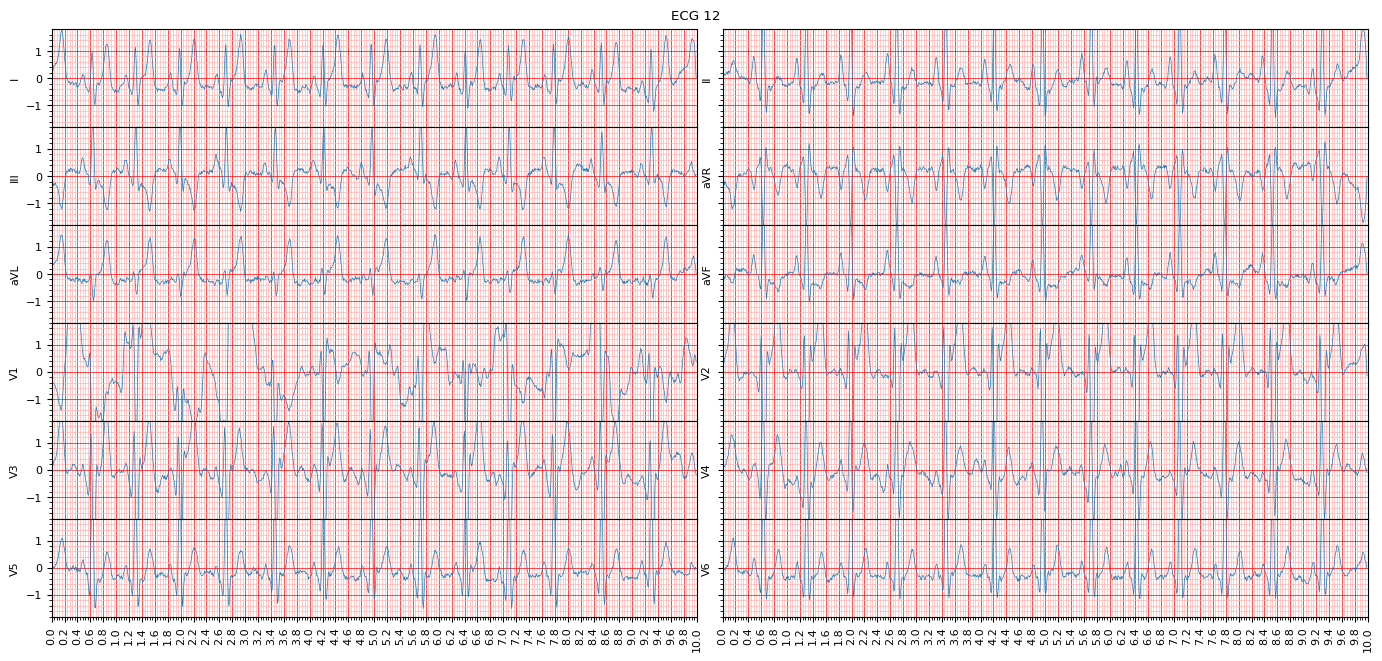

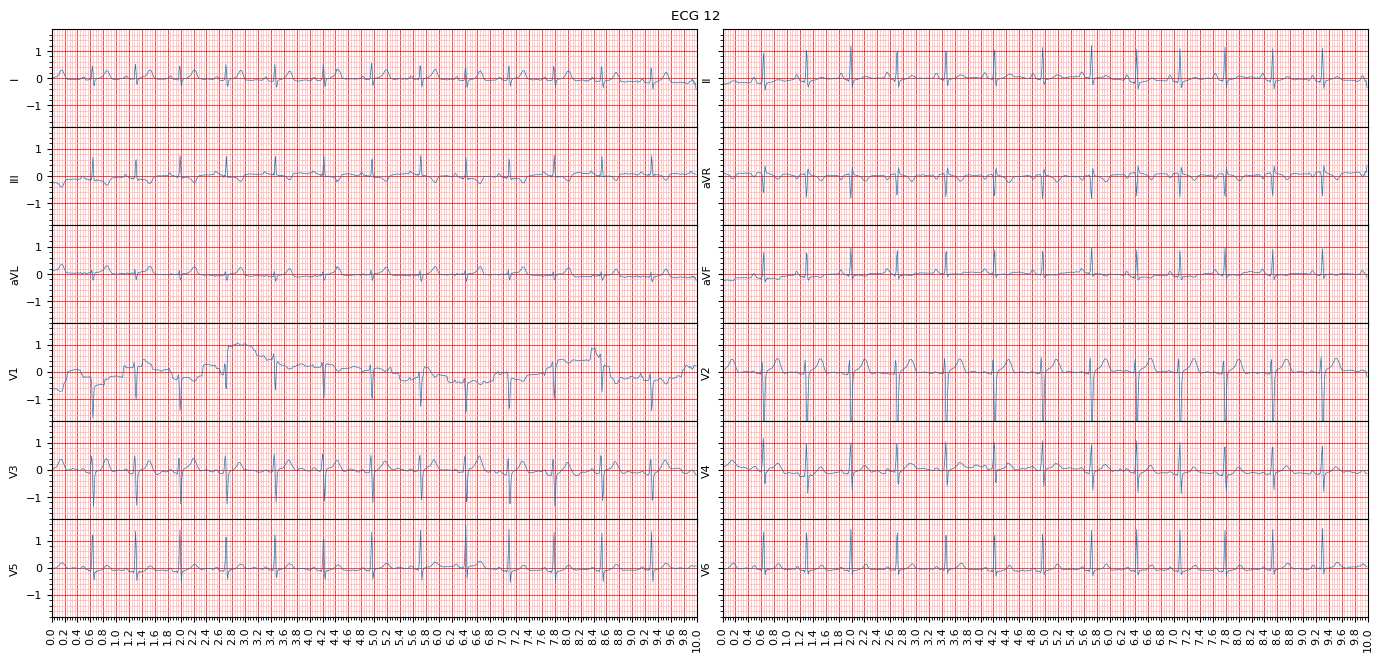

In [7]:
sr = 100
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X_final, (0,2,1))[5], sample_rate=sr)
    ecg_plot.plot_12(tf.transpose(X, (0,2,1))[5], sample_rate=sr)

### Splitting data in train, validation, testing data set

In [8]:

with tf.device('/CPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 18)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89) & (y_train >= 18)]

        rX_val = X_val[(y_val < 89) & (y_val >= 18)]
        ry_val = y_val[(y_val < 89) & (y_val >= 18)]

        rX_test = X_test[(y_test < 89) & (y_test >= 18)]
        ry_test = y_test[(y_test < 89) & (y_test >= 18)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


### Data manipulation
* The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards as stated by the PTB-XL data page.

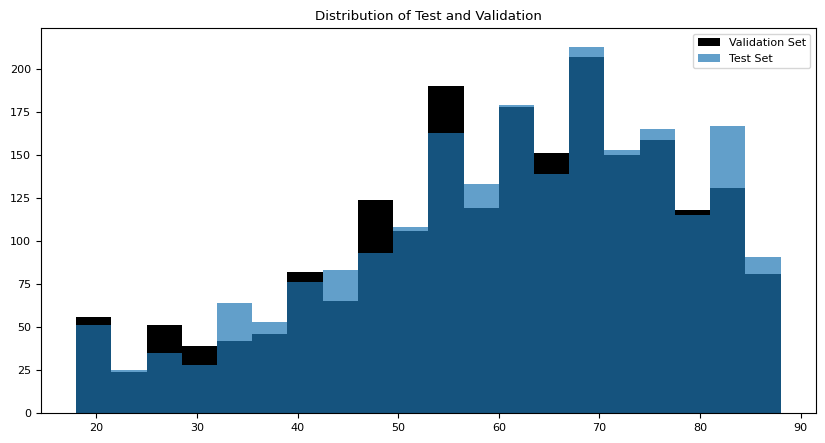

In [9]:
with tf.device('/CPU:0'):
    # Plotting the histograms
    plt.figure(figsize=(10,5))
    hist_val = plt.hist(y_val, label='Validation Set', color="black", bins = 20)
    hist_test = plt.hist(y_test, label='Test Set', alpha = 0.7, bins = 20)

    plt.legend()
    plt.title("Distribution of Test and Validation")

    plt.show()

### Distribution of Age
* Each following bar plots explain the decisions to cut down the data. 

#### Original data

Text(0.5, 1.0, 'Distribution of Age')

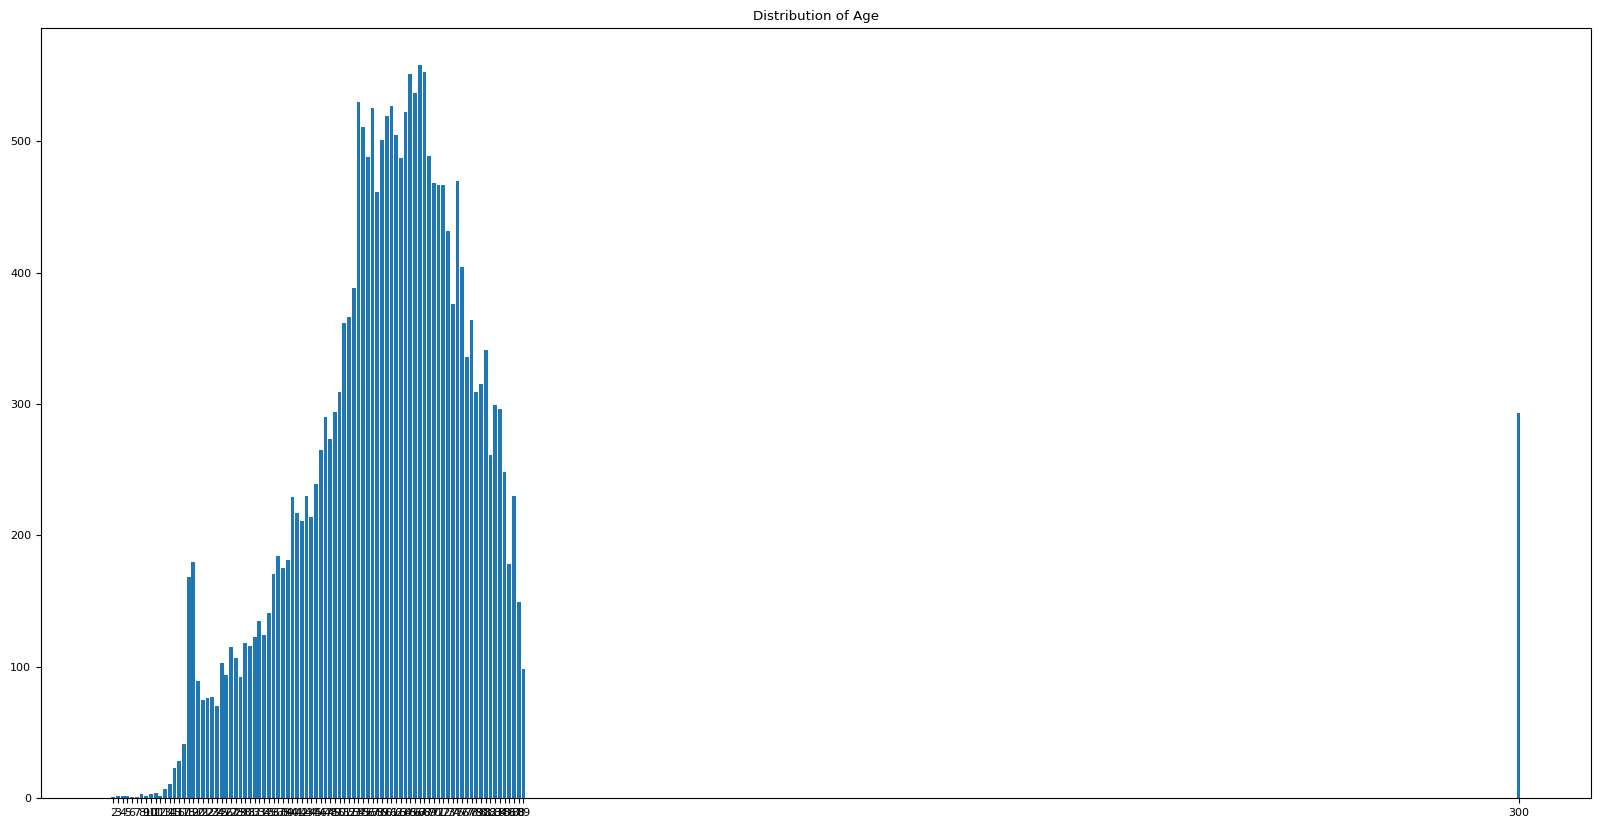

In [10]:
uniques, counts = np.unique(pd.DataFrame(Y.age), return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

#### Data cut off for patients older than 88

Text(0.5, 1.0, 'Distribution of Age')

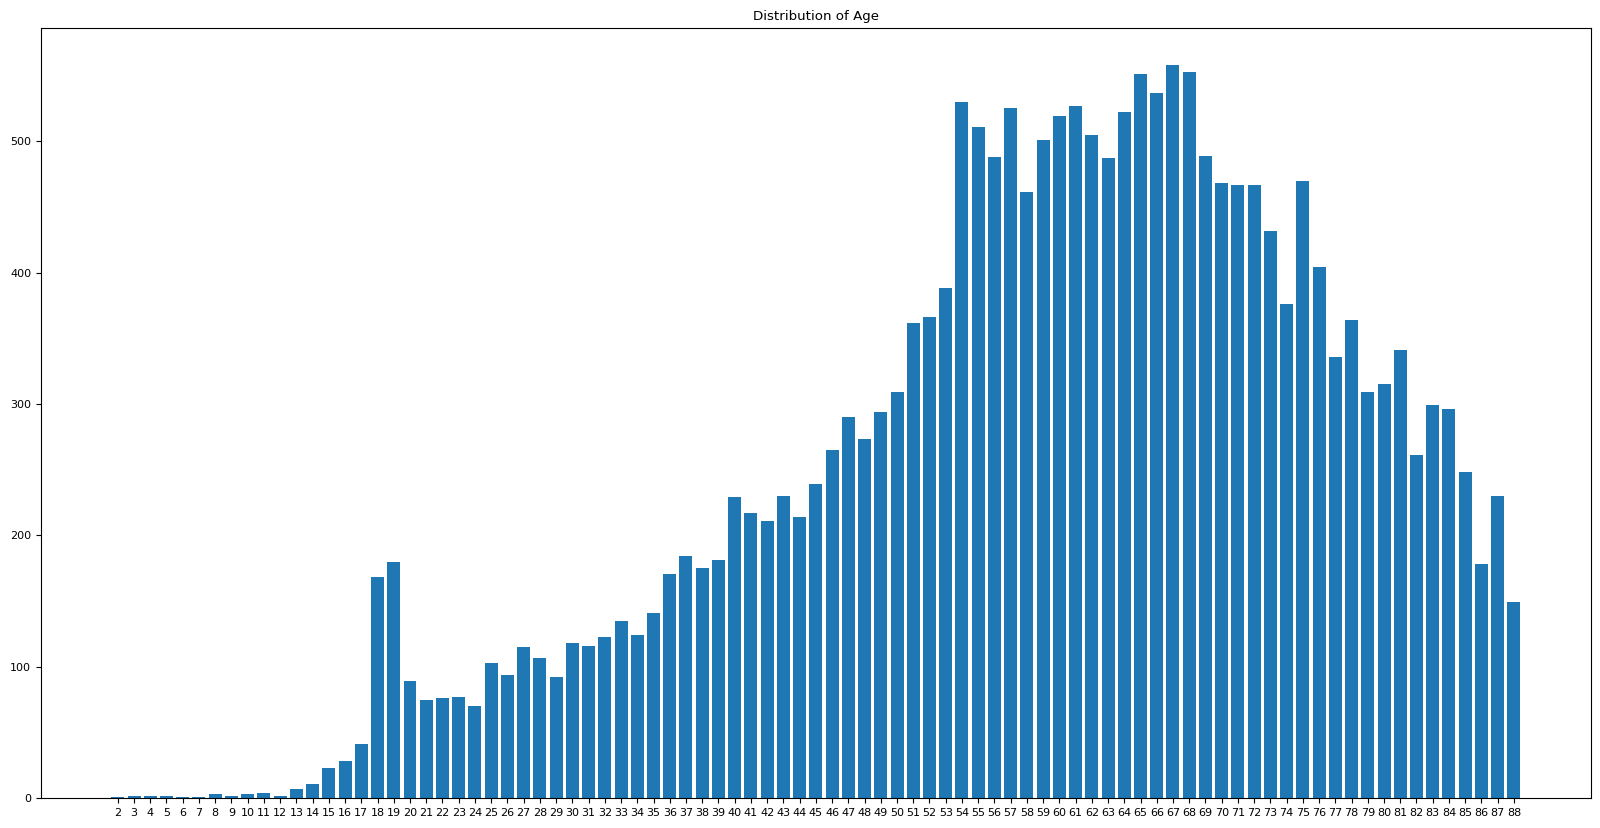

In [11]:
y_age_demo = Y[Y.age < 89].age
uniques, counts = np.unique(pd.DataFrame(y_age_demo), return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

#### Additional cut off for sparse data
* Including ages with very little data for the model to learn on will affect the models performance. 
* The model would not be able to effectively predict these ages properly any way. 

Text(0.5, 1.0, 'Distribution of Age')

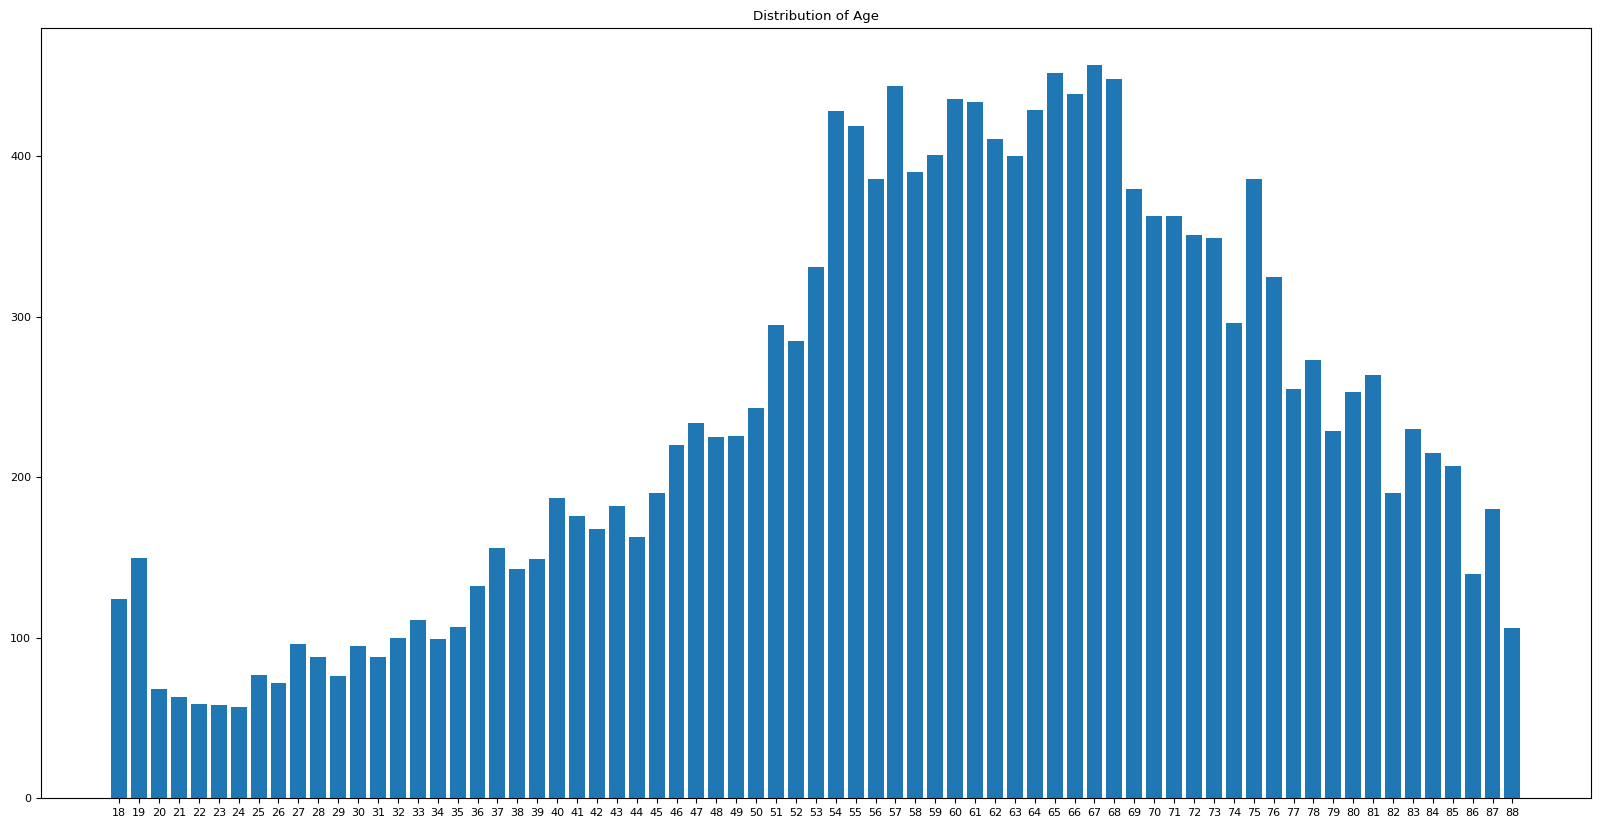

In [12]:
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

## Modelling

### Model 1
* Model inspired by https://www.ahajournals.org/doi/full/10.1161/CIRCEP.119.007284
* Fairly large and demanding model even after batching
* Yielded (mae: 10.86), (mse: 230.31)
* **Demonstrates the bias-variance trade-off**
    * We would think that highly individualized ecgs require a complex model to capture intricate patterns, however this complex model is actually capturing a lot of noise from the thousands of ecgs and makes it difficult to generalize results when it sees new data. 
    * Smaller models may not be able to capture very intricate patterns but is much better at generlaizing results from the training data to the validation and test data. 
* The learning rate was also adjusted to a 0.0003 which is relatively small. 

In [13]:

tf.debugging.disable_traceback_filtering

# Batching
batch_size = 64   # Batch size determines the amount of data processed each round
num_epochs = 20   # All of the data is processed a certain number of time repetedly. Based on the number of epochs. 
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))   # Grouping the X and Y together. Similar to zipping

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(X_train))   # We are able to shuffle both the X and Y the same because they are grouped. 
dataset = dataset.batch(batch_size)    # The input data is split into the batch size


# Creating the model
ecg_age_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation= 'linear')
])


# Compiling the model
ecg_age_model_1.compile(loss = tf.keras.losses.mse,
                    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                    metrics = ['mae'])


# Call Backs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)


# Train the model

#ecg_age_model_1.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))   # Performing data validation to verify model's performance on blind data.

# Smaller model
* Following my previous presumption, I created a smaller model with less neurons and layers. 
* The learning rate with increased 10 fold to compensate for the simplicity of the model. 
* Any patterns that this model is able to pick up will be updated more frequently.
* Results: (mae: 8.64)  (mse: 121.79)

In [14]:
X_train.shape, y_train.shape

((17022, 1000, 12), (17022,))

In [15]:
with tf.device('/GPU:0'):
    # Batching
    batch_size = 64   # Batch size determines the amount of data processed each round
    num_epochs = 20   # All of the data is processed a certain number of time repetedly. Based on the number of epochs. 
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))   # Grouping the X and Y together. Similar to zipping

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(X_train))   # We are able to shuffle both the X and Y the same because they are grouped. 
    dataset = dataset.batch(batch_size)    # The input data is split into the batch size


    # Creating the model
    ecg_age_model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
        tf.keras.layers.Flatten(),


        tf.keras.layers.Dense(64, activation= 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(1, activation= 'linear')
    ])


    # Compiling the model
    ecg_age_model_2.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.003),
                        metrics = ['mse'])


    # Learning rate scheduler
    early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



    # Fitting the model
    history_4 = ecg_age_model_2.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))

Epoch 1/20
266/266 [==============================] - 12s 27ms/step - loss: 13.1627 - mse: 291.3868 - val_loss: 18.5198 - val_mse: 472.1119
Epoch 2/20
266/266 [==============================] - 5s 20ms/step - loss: 11.1530 - mse: 198.0882 - val_loss: 12.0418 - val_mse: 219.4099
Epoch 3/20
266/266 [==============================] - 5s 21ms/step - loss: 10.4937 - mse: 176.4507 - val_loss: 12.2885 - val_mse: 227.3473
Epoch 4/20
266/266 [==============================] - 6s 22ms/step - loss: 10.4685 - mse: 175.5344 - val_loss: 11.1308 - val_mse: 193.0975
Epoch 5/20
266/266 [==============================] - 6s 22ms/step - loss: 10.2358 - mse: 167.7594 - val_loss: 9.3895 - val_mse: 140.7108
Epoch 6/20
266/266 [==============================] - 6s 22ms/step - loss: 10.1593 - mse: 164.8649 - val_loss: 9.0238 - val_mse: 128.2164
Epoch 7/20
266/266 [==============================] - 6s 22ms/step - loss: 9.9434 - mse: 159.9386 - val_loss: 9.5605 - val_mse: 144.7507
Epoch 8/20
266/266 [==========

In [16]:
ecg_age_model_2.evaluate(X_test, y_test)  # Performs an evaluation on the testing data that may not be tuned to the hyperparameters. 
                                          # Final and most accurate evaluation of model's performance

67/67 [==============================] - 0s 7ms/step - loss: 8.7244 - mse: 123.3950


[8.72439956665039, 123.39500427246094]

In [17]:
tf.saved_model.save(ecg_age_model_2, "../saved_models/100hz/age_models/age_model_1")

INFO:tensorflow:Assets written to: ../saved_models/100hz/age_models/age_model_1\assets


INFO:tensorflow:Assets written to: ../saved_models/100hz/age_models/age_model_1\assets


## Performance Analysis

### Performance Visualizer
* Each unique age has a boxplot describing the distribution of the model's predictions. 
* A scatter plot is overlayed to make accurate comparisons easier. The black dots represent a 100% accurate prediction. 

In [18]:
import seaborn as sns   # Remeber to install seaborn

def age_bar(model, X, Y):
    # Predict on train
    Y_pred = model.predict(X)


    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(Y), 'Values': np.squeeze(Y_pred)})  # Merges the Actual and predicted data

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 10))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
    category_positions = range(len(data['Category'].unique()))
    plt.scatter(category_positions, np.unique(np.squeeze(Y)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.yticks(range(0, 110, 5)) 
    plt.title("Evaluation of the Model")
    plt.show()

#### Training Performance

532/532 [==============================] - 3s 5ms/step


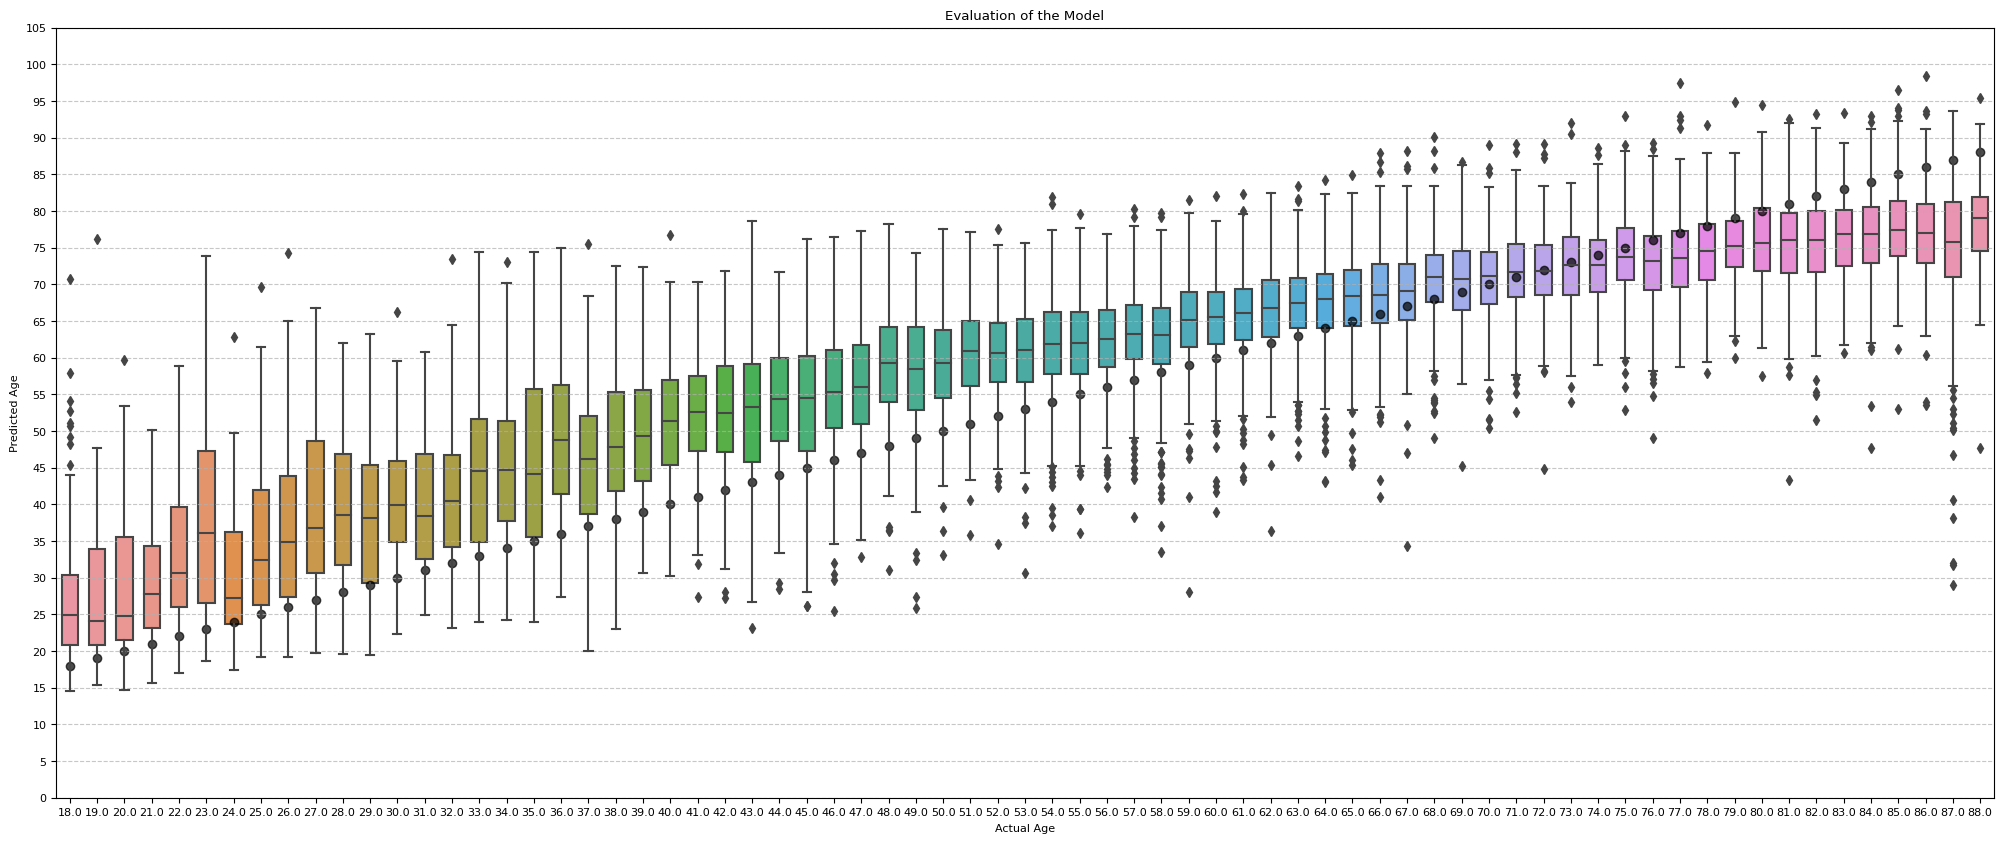

In [19]:
age_bar(ecg_age_model_2, X_train, y_train)

67/67 [==============================] - 0s 5ms/step


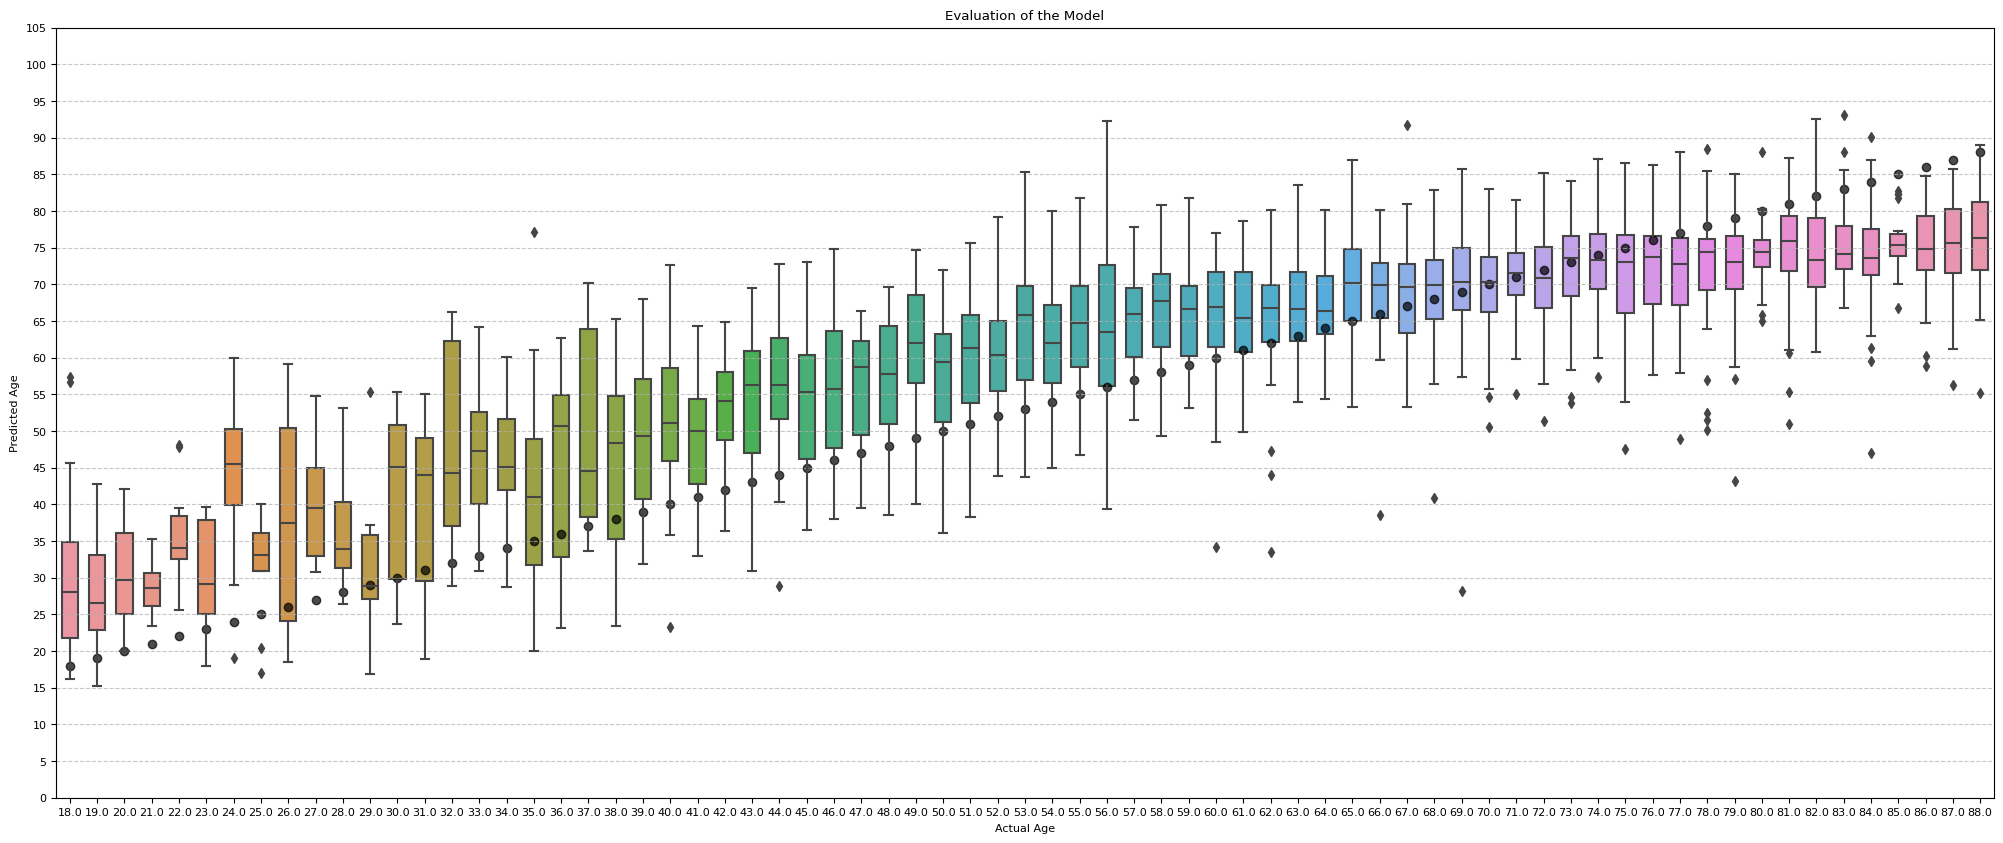

In [20]:
age_bar(ecg_age_model_2, X_test, y_test)

### Real sample Performance

67/67 [==============================] - 1s 8ms/step


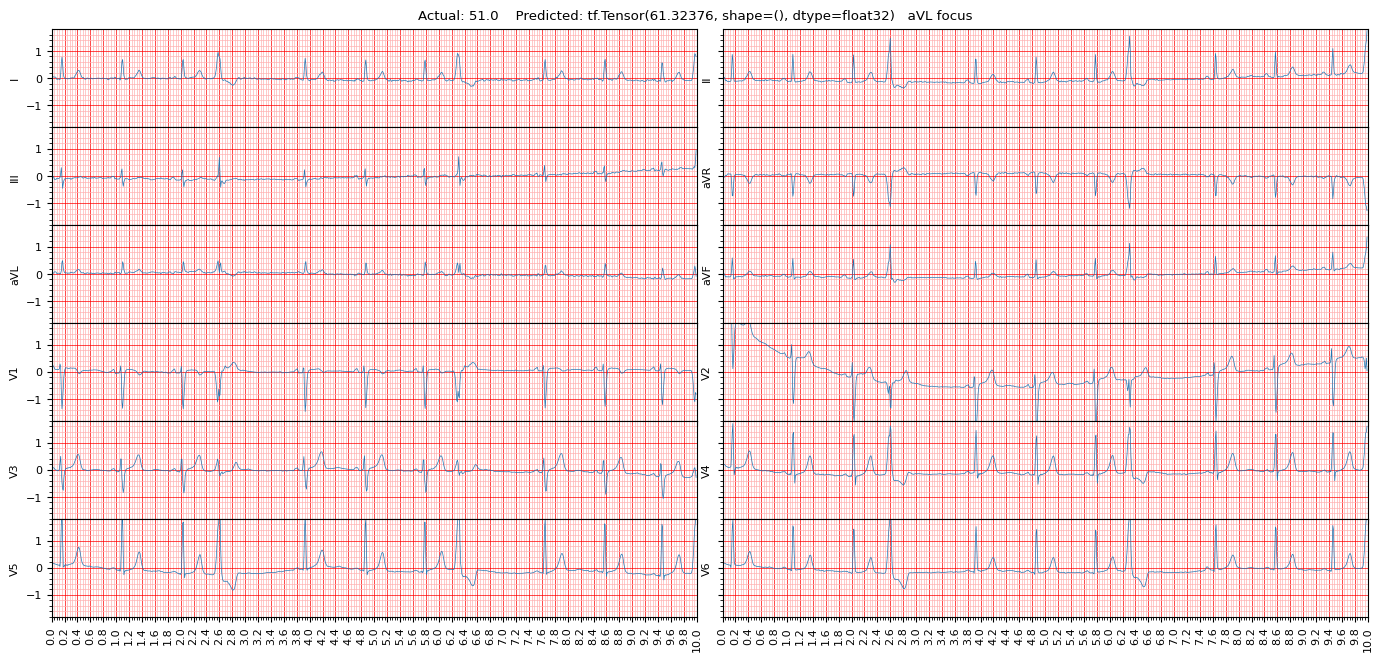

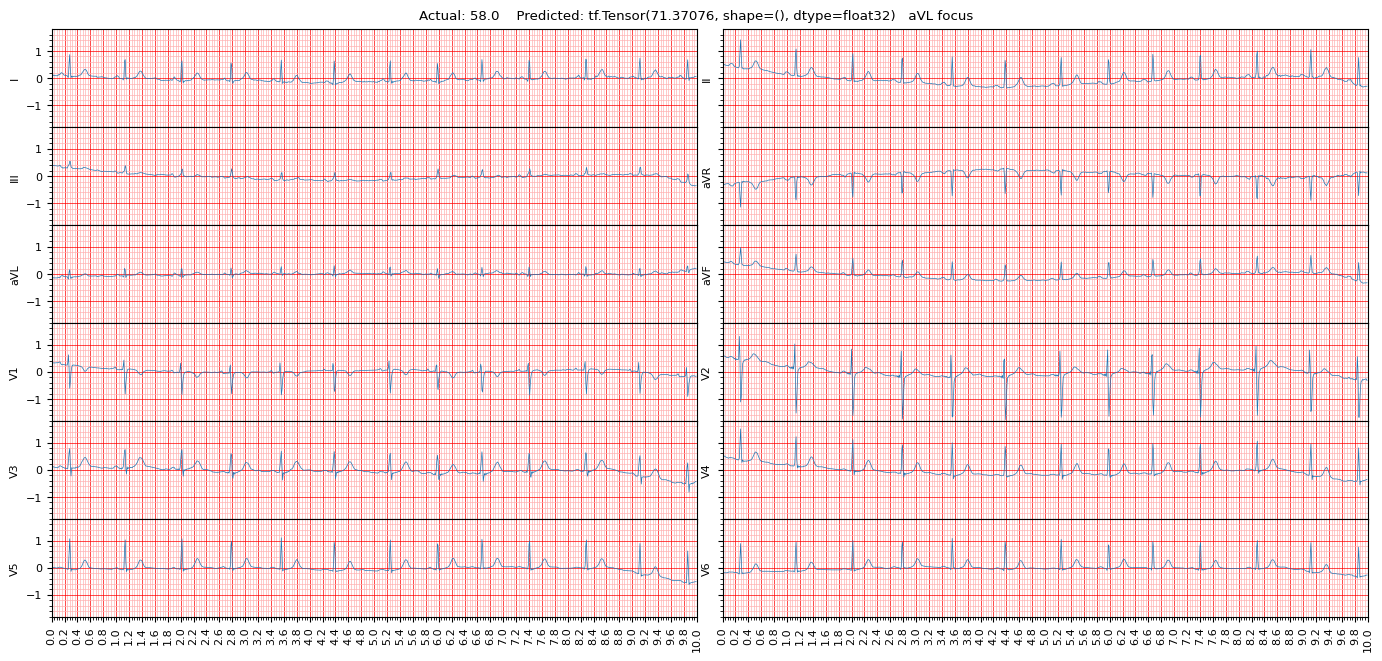

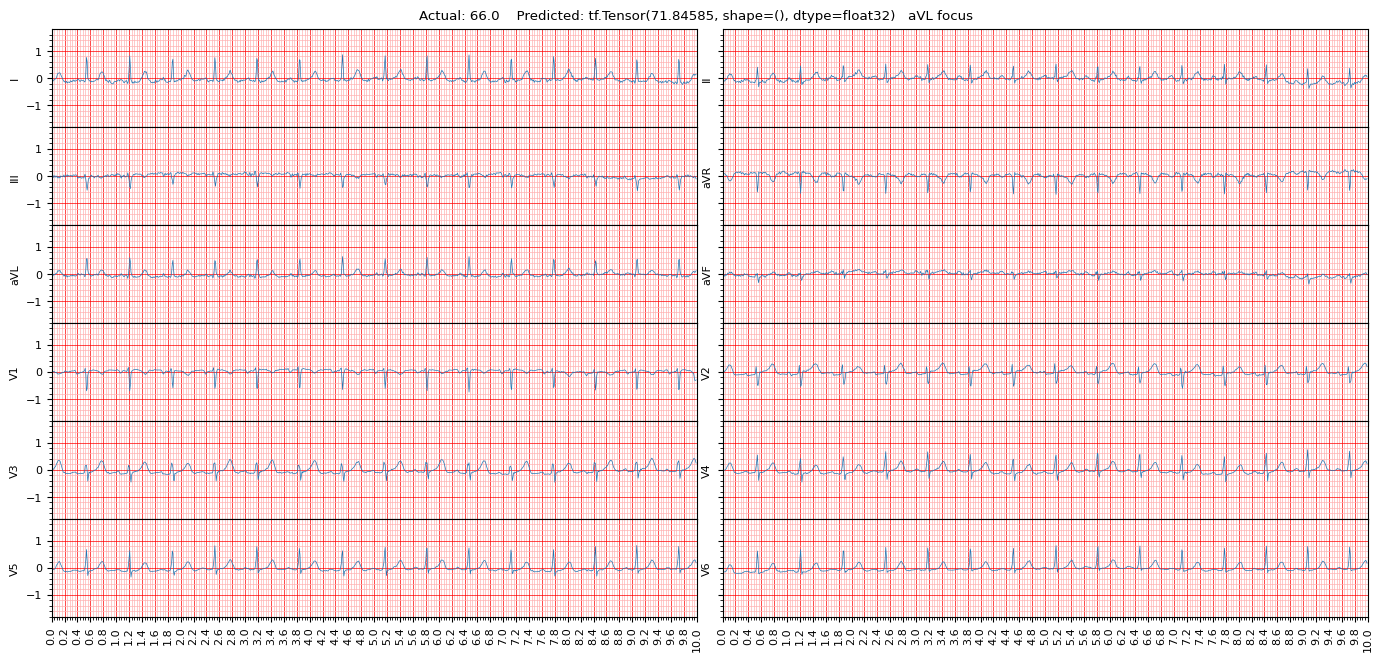

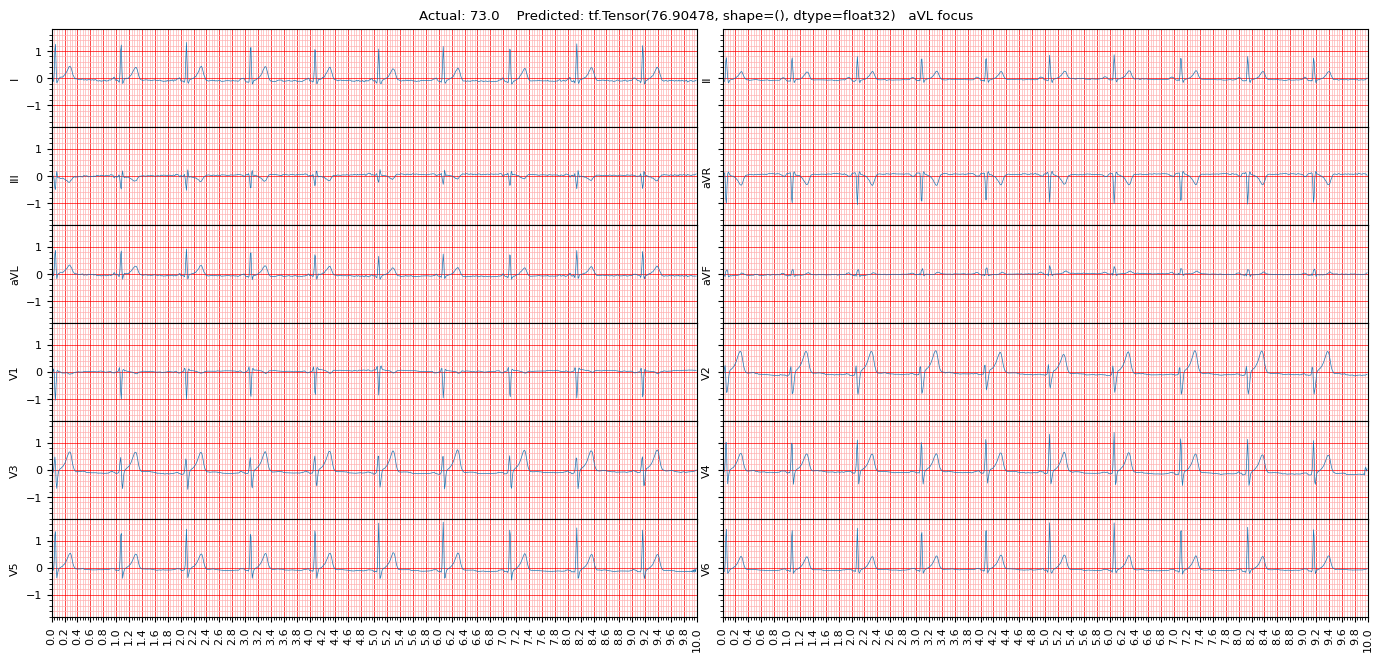

In [21]:
from random import choice

def visualize(y_test, X_test, model):
    y_pred = tf.squeeze(model.predict(X_test))
    for i in range(4):
        ind = choice(range(1, len(X_test)))
        plot_title = ("Actual: " + str(y_test[ind]) + "    Predicted: " + str(y_pred[ind]) )
        ecg_plot.plot_12(tf.transpose(X, (0,2,1))[ind], sample_rate=100, title = plot_title + "   aVL focus")

with tf.device('/CPU:0'):
    visualize(y_test, X_test, ecg_age_model_2)

### Further Data manipulation (Daniel)

### Resampling

Text(0.5, 1.0, 'Distribution of Age')

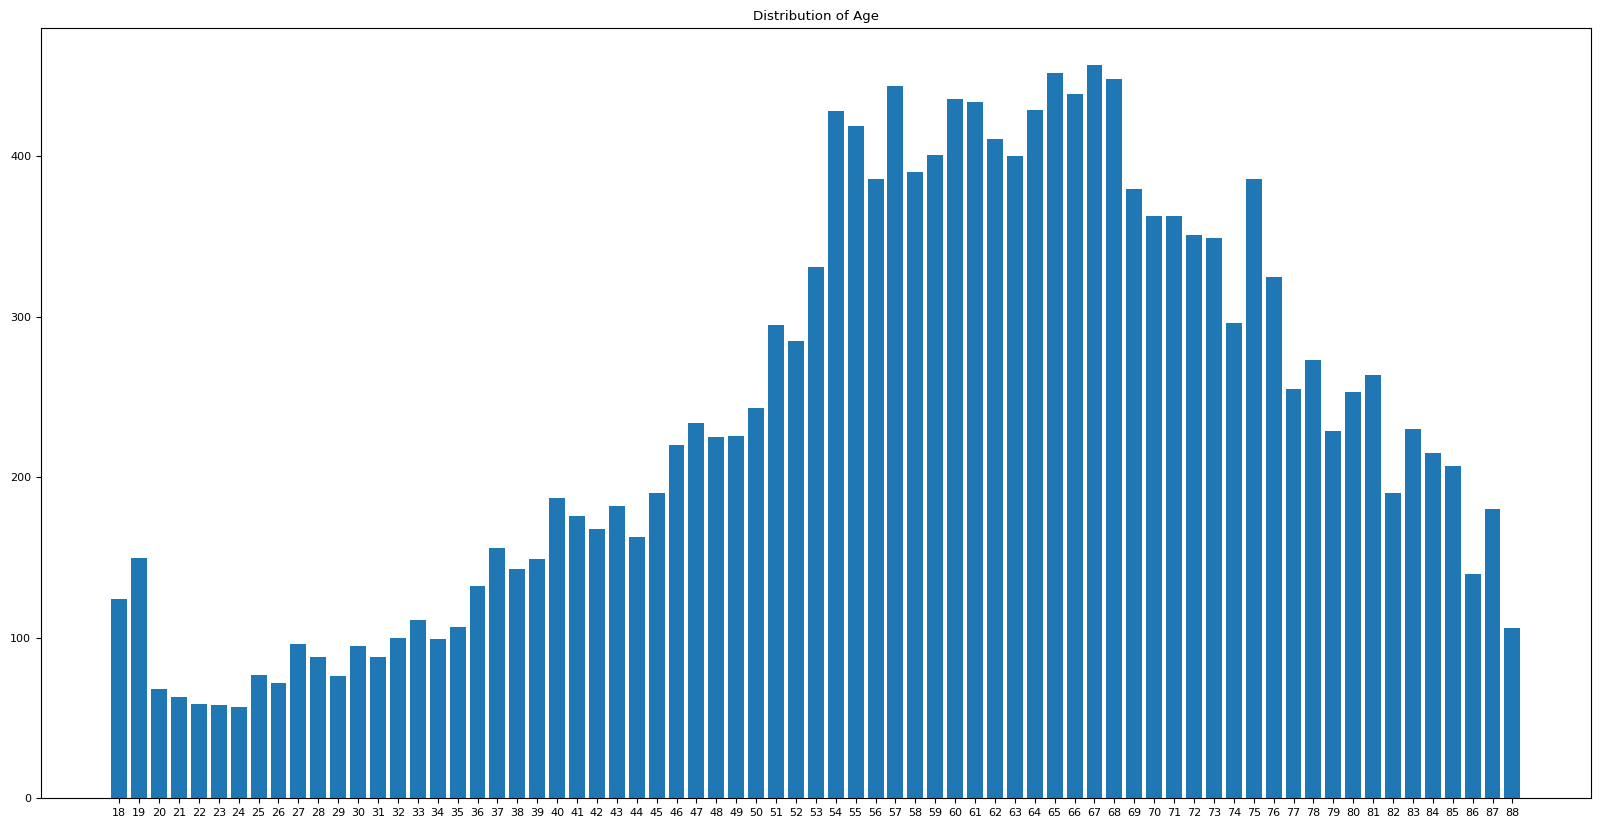

In [22]:
# Original Age Distribution Graph
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

(32447, 1000, 12)


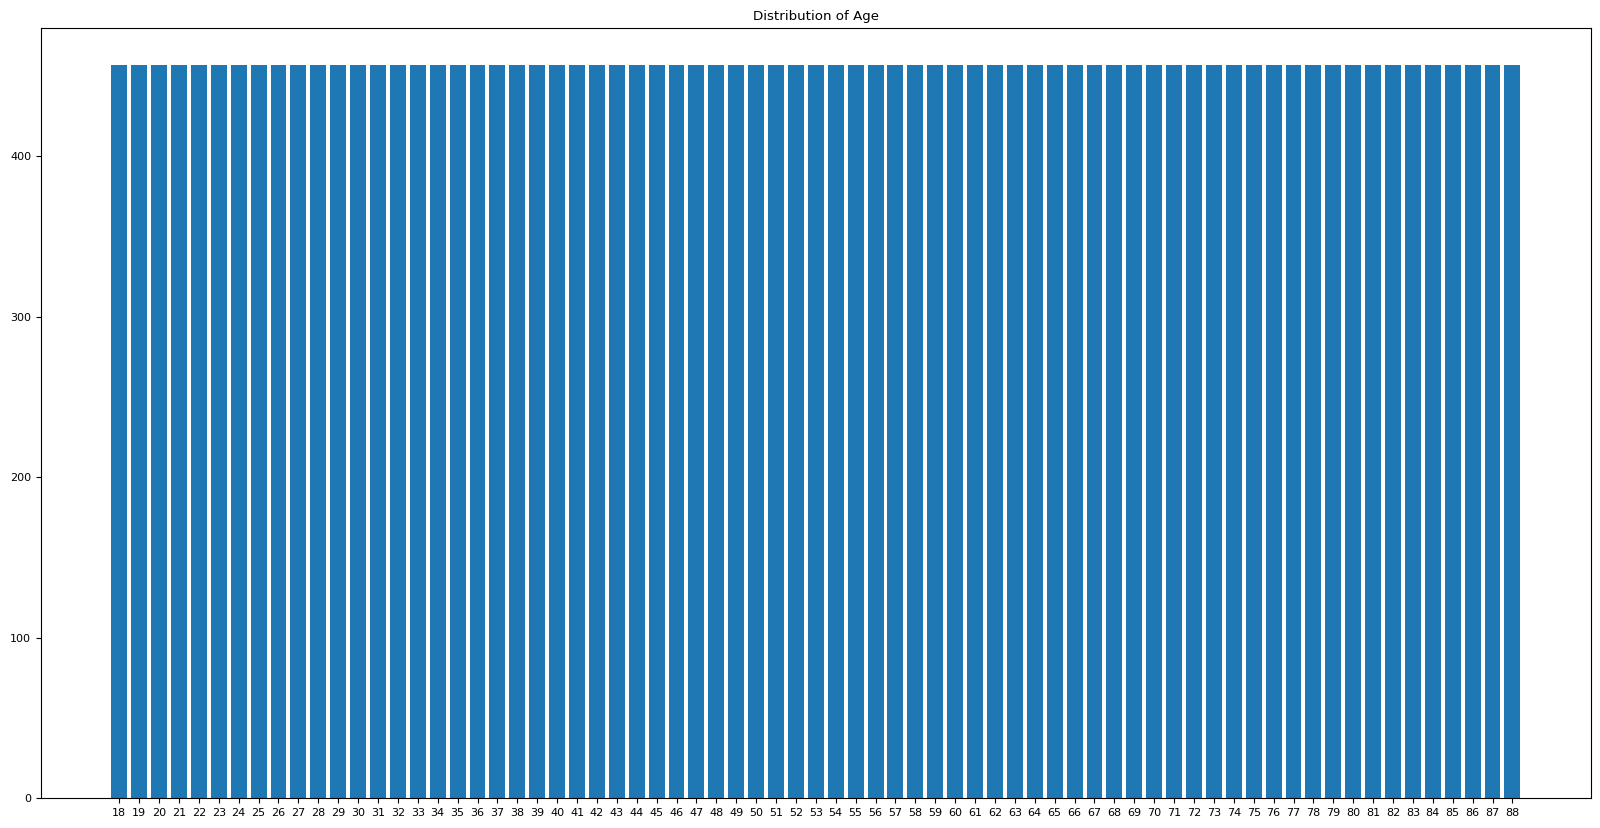

In [23]:
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
with tf.device('/CPU:0'):
    X_train_flat = tf.reshape(X_train, (X_train.shape[0], -1))

    oversampler = RandomOverSampler(sampling_strategy='not majority')
    X_train_resampled_flat, y_train_resampled = oversampler.fit_resample(X_train_flat, y_train)

    X_train_resampled = np.reshape(X_train_resampled_flat, (X_train_resampled_flat.shape[0], X_train.shape[1], X_train.shape[2]))
    print(X_train_resampled.shape)

    # Original Age Distribution Graph
    uniques, counts = np.unique(pd.DataFrame(y_train_resampled), return_counts=True)
    plt.figure(figsize=(20,10))
    plt.bar(uniques, counts)
    plt.xticks(uniques, rotation = 0)
    plt.title("Distribution of Age")

### Goals
* Create a saliency map overlaying the ecg plots
    * Highlights the most important regions or areas of an image that contribute significantly to the model's prediction.
    * Would be the in the form of a heatmap
* **Inspiration:** https://arxiv.org/ftp/arxiv/papers/2201/2201.04070.pdf